# Tutorial

This tutorial will walk you through the main features of Atoti by creating an application to analyze the sales of a company.

We'll see how to:

- Load normalized data in multiple tables to create a multidimensional cube.
- Define aggregated measures to provide application-specific and high-level insights.
- Build no-code interactive charts and tables in JupyterLab.
- Create dashboards in the built-in web app.

We encourage you to play this notebook in JupyterLab:

- Copy the tutorial: `python -m atoti.copy_tutorial tutorial`
- Open JupyterLab: `jupyter lab`
- Open the created **tutorial** directory and start playing its notebook.

For more information about a functionality, you can use the API reference or <kbd>Shift ⇧</kbd> + <kbd>Tab ⇥</kbd> on a Python symbol in JupyterLab.

## Getting started

### From CSV to Cube

In this part of the tutorial, you will create your first cube from a CSV file and learn multidimensional concepts such as _cube_, _dimension_, _hierarchy_, _measure_.

Let's start by creating a _session_:

In [1]:
import atoti as tt

Welcome to Atoti 0.8.7!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


In [2]:
session = tt.Session()

We can now load the data from a CSV file into an in-memory table called a _table_:

In [3]:
sales_table = session.read_csv("data/sales.csv", keys=["Sale ID"])

We can have a look at the loaded data.
They are sales from a company:

In [4]:
sales_table.head()

,Date,Shop,Product,Quantity,Unit price
Sale ID,,,,,
S000004293,2021-02-01,shop_13,CHA_23,1.0,60.0
S000002865,2021-01-20,shop_25,SHO_59,1.0,60.0
S000000008,2021-01-27,shop_8,TSH_8,1.0,20.0
S000001454,2021-01-21,shop_14,TSH_51,4.0,22.0
S000000010,2021-01-25,shop_10,TSH_10,1.0,24.0


We will come back to tables in details later, for now we will use the one we have to create a _cube_:

In [5]:
cube = session.create_cube(sales_table)

That's it, you have created your first cube!
But what's a cube exactly and how to use it?

### Multidimensional concepts

A _cube_ is a multidimensional view of some data, making it easy to explore, aggregate, filter and compare.
It's called a cube because each attribute of the data can be represented as a dimension of the cube:

<img alt="Multidimensional cube concept" src="images/cube-concept.svg" width="400" />

The axes of the cube are called _hierarchies_.
The purpose of multidimensional analysis is to visualize some numeric indicators at specific coordinates of the cube.
These indicators are called _measures_.
An example of measure would be the quantity of products sold.

We can list the hierarchies in our cube:

In [6]:
# Aliasing the hierarchies property to a shorter variable name because we will use it a lot.
h = cube.hierarchies
h

{('Sales', 'Sale ID'): <atoti.hierarchy.Hierarchy object at 0x12f6f2fd0>, ('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x12f4c2c50>, ('Sales', 'Date'): <atoti.hierarchy.Hierarchy object at 0x13a008810>, ('Sales', 'Shop'): <atoti.hierarchy.Hierarchy object at 0x13a008950>}

The cube has automatically created a hierarchy for each non numeric column: **Date**, **Product**, **Sale ID** and **Shop**.

You can see that the hierarchy are grouped into dimensions.
Here we have a single dimension called **Sales**, which is the name of the table the columns come from. We will see how to move hierarchies between dimensions later.

Hierarchies are also made of _levels_.
Levels of the same hierarchy are attributes with a parent-child relationship.
For instance, a city belongs to a country so **Country** and **City** could be the two levels of a **Geography** hierarchy.

At the moment, we only have single-level hierarchies.

In [19]:
l = cube.levels

Let's have a look at the measures of the cube that have been inferred from the data:

In [20]:
l

In [8]:
m = cube.measures
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x13a024110>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x13a024190>, 'Unit price.MEAN': <atoti.measure.Measure object at 0x13a0241d0>, 'Unit price.SUM': <atoti.measure.Measure object at 0x13a024210>, 'Quantity.MEAN': <atoti.measure.Measure object at 0x13a024250>, 'Quantity.SUM': <atoti.measure.Measure object at 0x13a024290>}

The cube has automatically created the _sum_ and _mean_ aggregations for all the numeric columns of the dataset.

Note that a measure isn't a single result number, it's more a formula that can be evaluated for any coordinates of the cube.

For instance, we can query the _grand total_ of **Quantity.SUM**, which means summing the sold quantities over the whole dataset:

<img alt="Grand total" src="images/grand-total.svg" width="400" />

In [9]:
cube.query(m["Quantity.SUM"])

,Quantity.SUM
0,"8,077.00"


But we can also _dice_ the cube to get the quantity for each **Shop**, which means taking one _slice_ of the cube for each **Shop**:

<img alt="Dicing the cube" src="images/slices.svg" width="400" />

In [10]:
cube.query(m["Quantity.SUM"], levels=[l["Shop"]])

,Quantity.SUM
Shop,
shop_0,202.00
shop_1,202.00
shop_10,203.00
shop_11,203.00
shop_12,201.00
shop_13,202.00
shop_14,202.00
shop_15,202.00
shop_16,201.00


We can _slice_ on a single **Shop**:

<img alt="Slicing the cube" src="images/slice.svg" width="400" />

In [11]:
cube.query(
    m["Quantity.SUM"],
    filter=l["Shop"] == "shop_0",
)

,Quantity.SUM
0,202.00


We can dice along 2 different axes and take the quantity per product and date.

<img alt="Pivot table" src="images/pivot-table.svg" width="400" />

In [12]:
cube.query(m["Quantity.SUM"], levels=[l["Date"], l["Product"]])

Quantity.SUM
Date       Product             
2021-01-06 BED_24          8.00
           BED_25          4.00
           BED_26          6.00
           BED_27          4.00
           BED_3           2.00
...                         ...
2021-02-04 TSH_52          6.00
           TSH_53          4.00
           TSH_7           3.00
           TSH_8           5.00
           TSH_9           3.00

[1830 rows x 1 columns]

We can even combine these operations to slice on one hierarchy and dice on the two others:

<img alt="Slice and dice" src="images/slice-and-dice.svg" width="400" />

In [13]:
cube.query(
    m["Quantity.SUM"],
    levels=[l["Date"], l["Product"]],
    filter=l["Shop"] == "shop_0",
)

Quantity.SUM
Date       Product             
2021-01-15 BED_24          1.00
           BED_26          1.00
           BED_3           1.00
           BED_4           1.00
           BED_46          1.00
...                         ...
2021-02-04 TSH_51          2.00
           TSH_52          1.00
           TSH_53          1.00
           TSH_7           1.00
           TSH_9           1.00

[125 rows x 1 columns]

### Interactive widget

So far we have used [cube.query()](../../api/atoti.Cube.query.rst) which returns a pandas DataFrame but a better way to visualize multidimensional data is a pivot table.
With Atoti's JupyterLab extension, you can create interactive widgets such as pivot tables and charts directly into your notebook.

This will create a widget and open the Atoti tab on the left with tools to manipulate the widget.

Let's start by creating a pivot table:

- Run [session.widget](../../api/atoti.Session.widget.rst).
- In the left panel, click on a measure such as **Quantity.SUM** to add it.
- Click on a hierarchy such as **Date** to get the quantity per date.
- Drag and drop another hierarchy such as **Product** to the **Columns** section to get the quantity sold per day and per product.

![First pivot table](images/first-pivot-table.gif)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
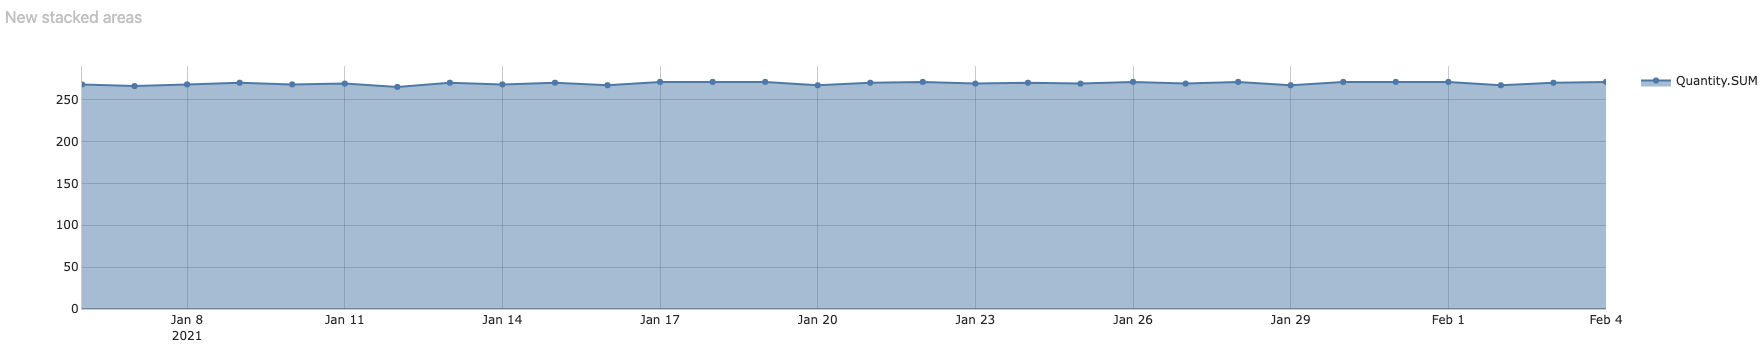

In [14]:
session.widget

Tables can be switched to charts.

For instance let's switch to a line chart.

![First chart](images/first-chart.gif)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
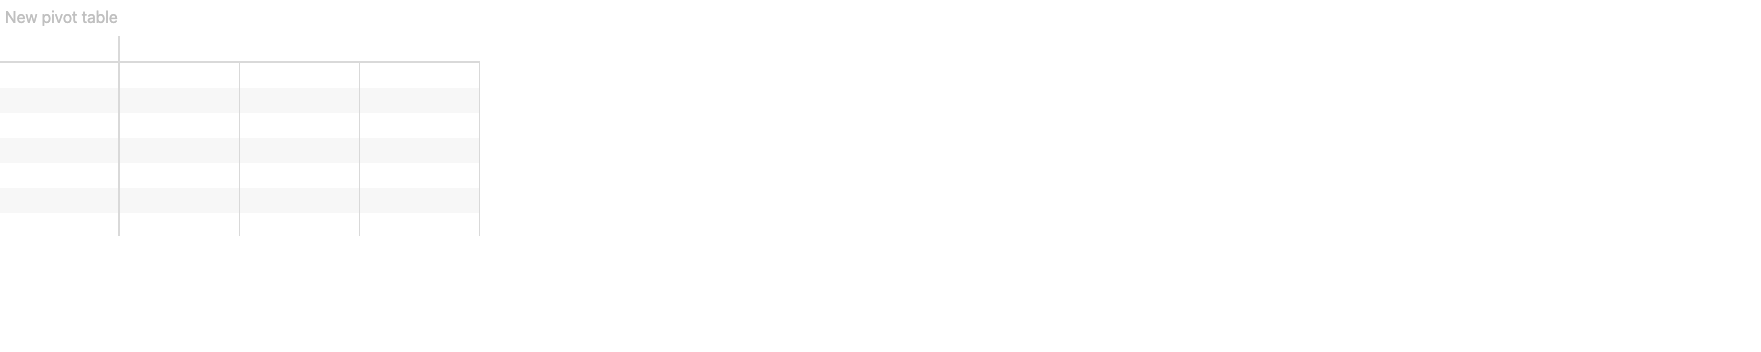

In [15]:
session.widget

### Drilldown and filters

Multidimensional analysis is meant to be done from top to bottom: start by visualizing the indicators at the top level then drilldown to explain the top figures with more details.

For instance, we can visualize some measures per date then drilldown on **Shop** for a specific date, then see the products sold by a specific shop on this date.

Using the previous cube representation, this is like zooming more and more on a part of the cube.

<img alt="Drilldown the cube" src="images/drilldown.svg" width="1200" />

![Drilldown](images/drilldown.gif)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
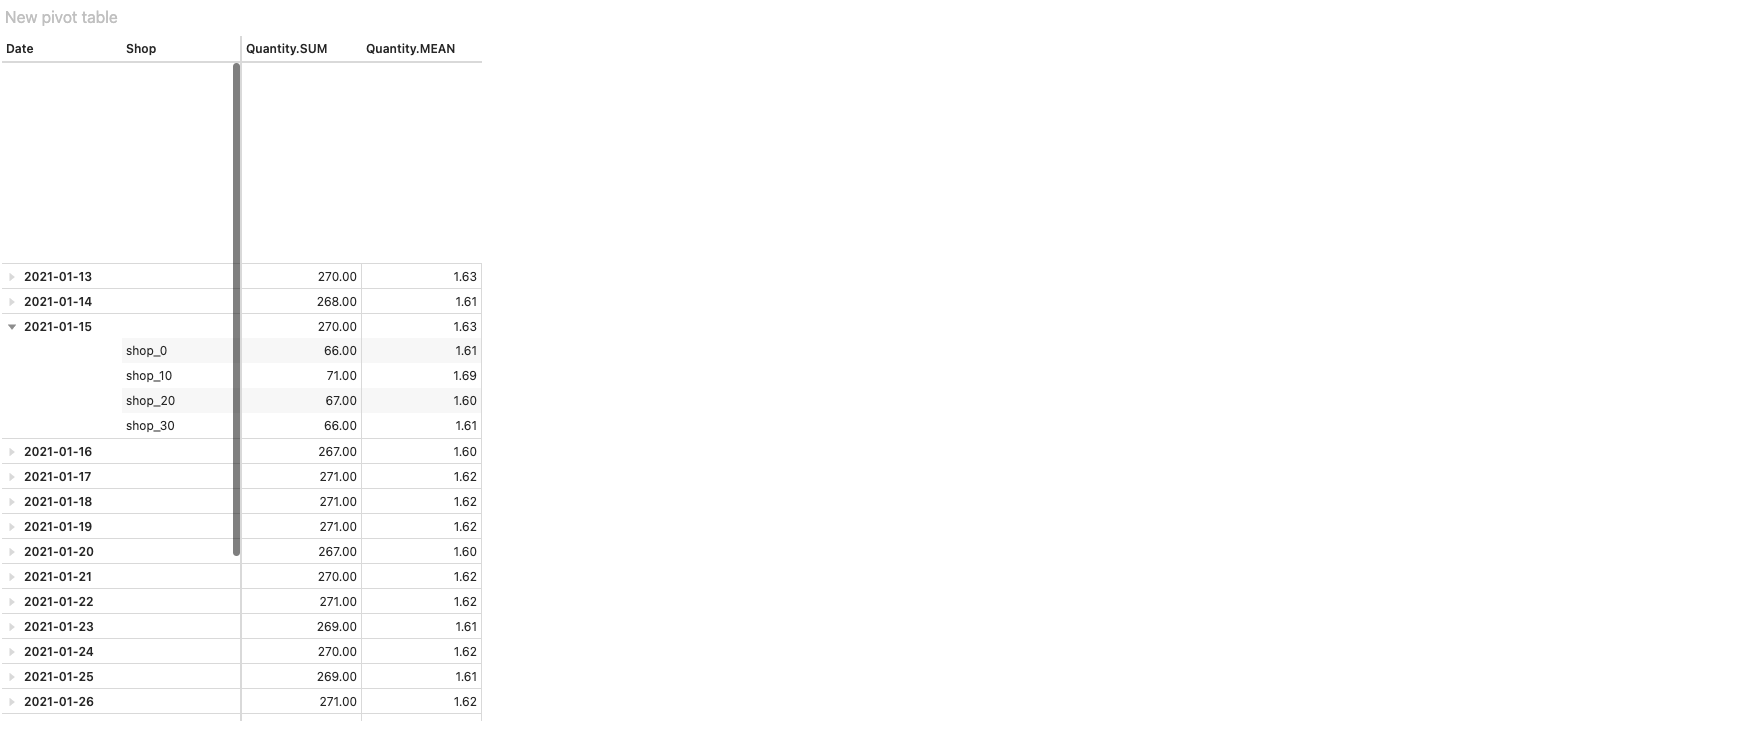

In [16]:
session.widget

Hierarchies can be filtered when building widgets.
Let's apply a filter on the previous chart and only visualize the quantity for a group of selected products.

![Chart filter](images/filter-chart.gif)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
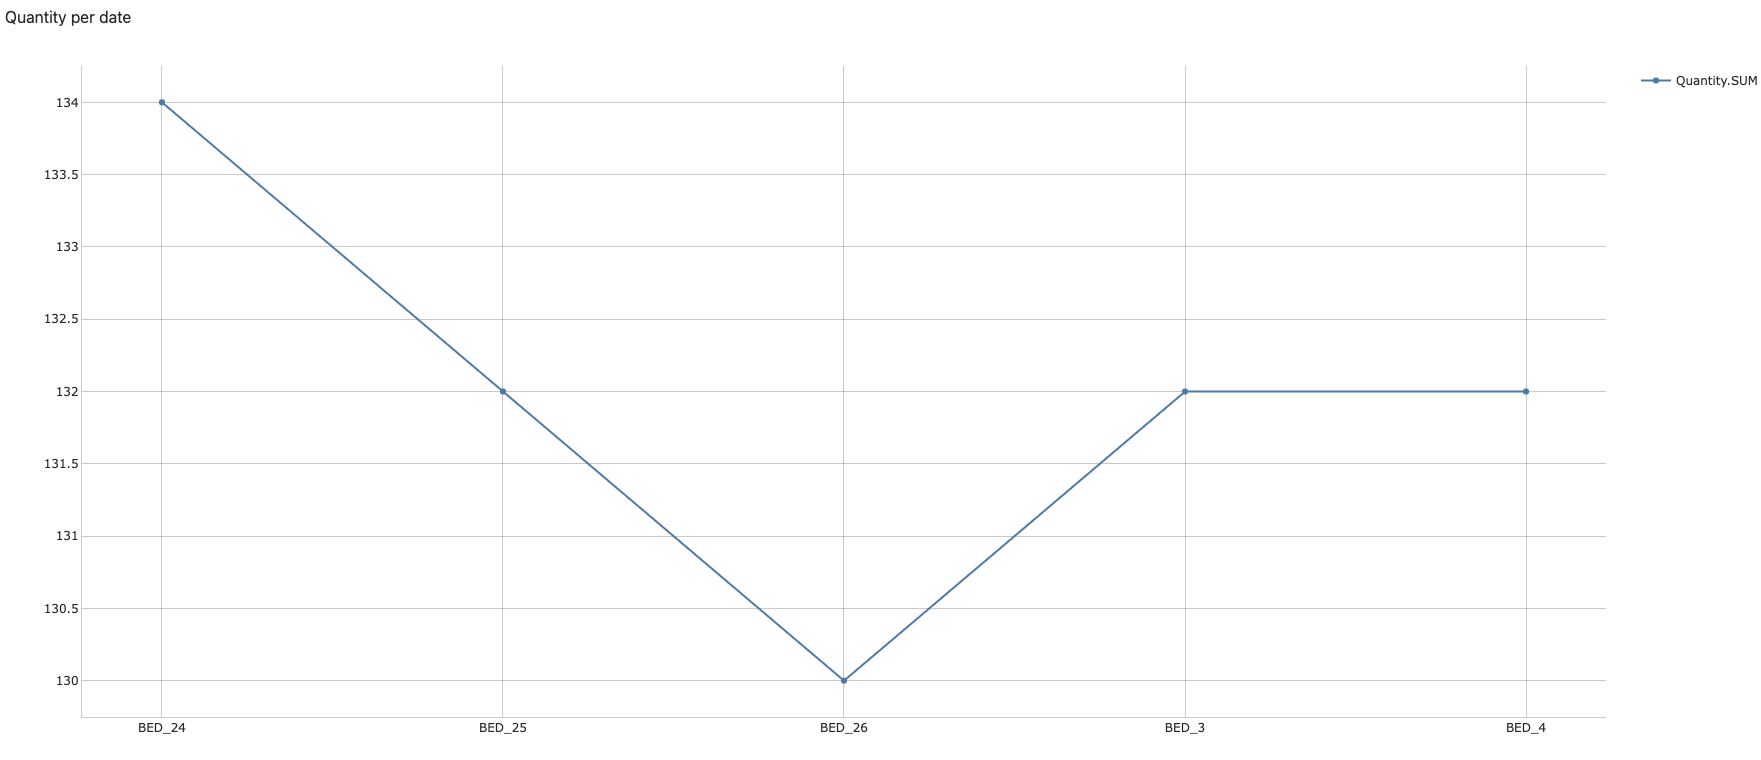

In [17]:
session.widget

### Dashboarding app

Being able to quickly build widgets inside a notebook without coding is nice to rapidly explore the data, iterate on your model and share some results.
However, to provide richer insights, dashboards are even better.
That's why Atoti comes with a web app that can be accessed outside of the notebook and where widgets can be laid out to form dashboards.

The app can be accessed with this link:

In [18]:
session.link

http://localhost:61530

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

Widgets built in the notebook can be saved in the app by right clicking on them and selecting **Save widget in app**.
They will then be available in the **Saved widgets** section.

![Saving widget in app](images/save-in-app.gif)

## Enriching the cube

In the previous section, you have learned how to create a basic cube and manipulate it.
We will now enrich this cube with additional attributes and more interesting measures.

### Join

Currently, we have very limited information about our products: only the ID.
We can load a CSV containing more details into a new table:

In [19]:
products_table = session.read_csv("data/products.csv", keys=["Product"])

Note that a table can have a set of keys.
These keys are the columns which make each line unique.
Here, it's the product ID.

If you try to insert a new row with the same keys as an existing row, it will override the existing one.

In [20]:
products_table.head()

,Category,Sub category,Size,Purchase price,Color,Brand
Product,,,,,,
TSH_10,Cloth,T-shirt,L,20.0,black,Over
TAB_22,Furniture,Table,2m40,280.0,blue,Basic
HOO_34,Cloth,Hoodie,M,38.0,brown,Over
BED_46,Furniture,Bed,Double,252.0,white,Basic
SHO_58,Cloth,Shoes,8,42.0,red,Over


This table contains the category, subcategory, size, color, purchase price and brand of the product.
Both tables have a **Product** column we can use to [join](../../api/atoti.Table.join.rst) them.

In [21]:
sales_table.join(products_table, sales_table["Product"] == products_table["Product"])

Note that this is a database-like join and not a pandas-like join.
All the details from `products_table` won't be inlined into `sales_table`.
Instead, this just declares a reference between these two tables that the cube can use to provide more analytical axes.

You can visualize the structure of the session's tables:

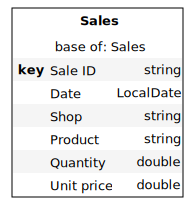

In [21]:
session.tables.schema

The new columns have been automatically added to the cube as hierarchies, in a dimension with the same name as the new table:

In [23]:
h

{('Products', 'Brand'): <atoti.hierarchy.Hierarchy object at 0x16a59b410>, ('Sales', 'Sale ID'): <atoti.hierarchy.Hierarchy object at 0x16a8d1450>, ('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x16a8e82d0>, ('Products', 'Sub category'): <atoti.hierarchy.Hierarchy object at 0x16a8e8190>, ('Products', 'Category'): <atoti.hierarchy.Hierarchy object at 0x16a8e9f50>, ('Products', 'Size'): <atoti.hierarchy.Hierarchy object at 0x16a8e8210>, ('Sales', 'Date'): <atoti.hierarchy.Hierarchy object at 0x16a8ea790>, ('Products', 'Color'): <atoti.hierarchy.Hierarchy object at 0x16a8e85d0>, ('Sales', 'Shop'): <atoti.hierarchy.Hierarchy object at 0x16a8eb310>}

You can use them directly in a new widget.
For instance, let's create a bar chart to visualize the mean price per subcategory of product:

![Price per category](images/price-per-category.png)

In [24]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

We can also make a donut chart to see how all the sales are distributed between brands:

![Donut chart brands](images/donut-chart.png)

In [ ]:
session.widget

Note that after the join we can add a new measure called **Purchase price.VALUE** based on the corresponding column of the joined table.
This measure represents the value of the column so it is only defined when all the keys of the joined table are expressed in the query.

In [ ]:
m["Purchase price.VALUE"] = tt.agg.single_value(products_table["Purchase price"])

For instance we can check the purchase price per **Product**:

In [ ]:
cube.query(m["Purchase price.VALUE"], levels=[l["Product"]])

In a similar way, we can enrich the data about the shops:

In [ ]:
shops_table = session.read_csv("data/shops.csv", keys=["Shop ID"])
shops_table.head()

In [ ]:
sales_table.join(shops_table, sales_table["Shop"] == shops_table["Shop ID"])
session.tables.schema

### New measures

So far we have only used the default measures which are basic aggregations of the numeric columns.
We can add new custom measures to our cube.

#### Max

We'll start with an aggregation taking the maximum price of the sales table:

In [ ]:
m["Max price"] = tt.agg.max(sales_table["Unit price"])

This new measure is directly available:

In [ ]:
cube.query(m["Max price"], include_totals=True, levels=[l["Category"]])

#### Fact-level operations

To compute aggregates based of data which comes directly from the columns of a table, you can pass the calculation directly to the desired aggregation function. This is more efficient than first converting the columns to measures before the aggregation.

Let's use this to compute the total amount earned from the sale of the products, as well as the average.

In [ ]:
m["Amount.SUM"] = tt.agg.sum(sales_table["Quantity"] * sales_table["Unit price"])
m["Amount.MEAN"] = tt.agg.mean(
    sales_table["Quantity"] * sales_table["Unit price"],
)

We can now plot the evolution of the sales per country over time:

![Amount per country over time](images/split-by-country.png)

In [ ]:
session.widget

#### Margin

Now that the price of each product is available from the products table, we can compute the margin.

We use the [OriginScope](../../api/atoti.OriginScope.rst) to perform the multiplication of the quantity sold by the purchase price for each **Product** and then do the sum.

In [ ]:
cost = tt.agg.sum(
    m["Quantity.SUM"] * tt.agg.single_value(products_table["Purchase price"]),
    scope=tt.OriginScope(l["Product"]),
)

In [ ]:
m["Margin"] = m["Amount.SUM"] - cost

We can also define the margin rate which is the ratio of the margin by the the sold amount:

In [ ]:
m["Margin rate"] = m["Margin"] / m["Amount.SUM"]

In [ ]:
cube.query(m["Margin"], m["Margin rate"], levels=[l["Product"]])

Let's use this margin rate to do a _Top 10_ filter to see the products with the best rate.

Note that you don't need to put the rate measure and the product level in the pivot table to apply the filter.

![top10 filter on the margin rate](images/top10-margin-rate.gif)

In [ ]:
session.widget

#### Cumulative sum over time

A cumulative sum is the partial sum of the data up to the current value.
For instance, a cumulative sum over time can be used to show how some measure changes over time.

In [ ]:
m["Cumulative amount"] = tt.agg.sum(
    m["Amount.SUM"], scope=tt.CumulativeScope(level=l["Date"])
)

![Cumulative amount](images/cumulative-amount.png)

In [ ]:
session.widget

#### Average per shop

Aggregations can also be combined.
For instance, we can sum inside a **Shop**: then take the average of this to see how much a table sales on average:

In [ ]:
m["Average amount per shop"] = tt.agg.mean(
    m["Amount.SUM"], scope=tt.OriginScope(l["Shop"])
)

In [ ]:
cube.query(
    m["Average amount per shop"], include_totals=True, levels=[l["Sub category"]]
)

### Multilevel hierarchies

So far, all our hierarchies only had one level but it's best to regroup attributes with a parent-child relationship in the same hierarchy.

For example, we can group the **Category**, **SubCategory** and **Product ID** levels into a **Product** hierarchy:

In [ ]:
h["Product"] = [l["Category"], l["Sub category"], l["Product"]]

And let's remove the old hierarchies:

In [ ]:
del h["Category"]
del h["Sub category"]

In [ ]:
h

We can also do it with **City**, **State or Region** and **Country** to build a **Geography** hierarchy.

Note that instead of using existing levels you can also define a hierarchy with the columns of the table the levels will be based on:

In [ ]:
h["Geography"] = [
    shops_table["Country"],
    shops_table["State or region"],
    shops_table["City"],
]
del h["Country"]
del h["State or region"]
del h["City"]

As we are restructuring the hierarchies, let's use this opportunity to also change the dimensions.

A dimension regroups hierarchies of the same concept.

We can move the new **Geography** hierarchy to its own dimension:

In [ ]:
h["Geography"].dimension = "Location"
h

With that, we can define new measures taking advantage of the multilevel structure.
For instance, we can create a measure indicating how much a product contributes to its subcategory:

In [ ]:
m["Parent category amount"] = tt.parent_value(
    m["Amount.SUM"], degrees={h[("Products", "Product")]: 1}
)

In [ ]:
m["Percent of parent amount"] = m["Amount.SUM"] / m["Parent category amount"]

![Percent of parent](images/percent-of-parent.gif)

In [ ]:
session.widget

## Polishing the cube

### Deleting or hiding measures

Some measures have been automatically created from numeric columns but are not useful.
For instance, **Unit Price.SUM** does not really make sense as we never want to sum the unit prices.
We can delete it:

In [ ]:
del m["Unit price.SUM"]

Other measures have been used while building the project only as intermediary steps but are not useful to the end users in the app.
We can hide them from the UI (they will remain accessible in Python):

In [ ]:
m["Parent category amount"].visible = False

### Measure folders

Measures can be rearranged into folders.

In [ ]:
for measure in [
    m["Amount.MEAN"],
    m["Amount.SUM"],
    m["Average amount per shop"],
    m["Cumulative amount"],
    m["Percent of parent amount"],
]:
    measure.folder = "Amount"

In [ ]:
m

### Measure formatters

Some measures can be formatted for a nicer display.
Classic examples of this is changing the number of decimals or adding a percent or a currency symbol.

Let's do this for our percent of parent amount and margin rate:

#### Before

In [ ]:
cube.query(m["Percent of parent amount"], m["Margin rate"], levels=[l["Category"]])

In [ ]:
m["Percent of parent amount"].formatter = "DOUBLE[0.00%]"
m["Margin rate"].formatter = "DOUBLE[0.00%]"

#### After

In [ ]:
cube.query(m["Percent of parent amount"], m["Margin rate"], levels=[l["Category"]])

## Simulations

Simulations are a way to compare several scenarios and do what-if analysis.
This helps understanding how changing the source data or a piece of the model impact the key indicators.

In Atoti, the data model is made of measures chained together.
A simulation can be seen as changing one part of the model, either its source data or one of its measure definitions, and then evaluating how it impacts the following measures.

### Source simulation

Let's start by changing the source.
With pandas or Spark, if you want to compare two results for a different versions of the entry dataset you have to reapply all the transformations to your dataset.
With Atoti, you only have to provide the new data and all the measures will be automatically available for both versions of the data.

We will create a new scenario using pandas to modify the original dataset.

In [ ]:
import pandas as pd

For instance, we can simulate what would happen if we had managed to purchase some products at a cheaper price.

In [ ]:
products_df = pd.read_csv("data/products.csv")
products_df.head()

In [ ]:
better_prices = {
    "TAB_0": 180.0,
    "TAB_1": 250.0,
    "CHA_2": 40.0,
    "BED_3": 110.0,
    "BED_4": 210.0,
}

In [ ]:
for product, purchase_price in better_prices.items():
    products_df.loc[
        products_df["Product"] == product, "Purchase price"
    ] = purchase_price
products_df.head()

We can now load this new dataframe into a new scenarios of the products table.

In [ ]:
products_table.scenarios["Cheaper purchase prices"].load_pandas(products_df)

The session now has two scenarios and the only differences between them are the lines corresponding to the products with better prices, everything else is shared between the scenarios and has not been duplicated: source scenarios in Atoti are memory-efficient.

<img alt="Source simulation" src="images/source-simulation.svg" width="750" />

Using the **Source Simulation** hierarchy we can display the margin of the scenario and compare it to the base case.

![Source simulation comparison](images/source-simulation.gif)

In [ ]:
session.widget

Note that all the existing measures are immediately available on the new data.
For instance, the margin rate still exists, and we can see that in this scenario we would have a better margin for the Furniture products.

![Margin rate per product category and scenario](images/margin-rate-per-scenario.gif)

In [ ]:
session.widget

### Parameter simulations

The other simulation technique is to create a parameter measure whose value can be changed for some coordinates.

When creating the simulation, you can choose at which granularity the modification applies.
For instance we can create a parameter measure whose value will change depending on the country.
Doing that, we can answer questions such as "What happens if there is a crisis in France and we sell 20% less?"

In [ ]:
country_simulation = cube.create_parameter_simulation(
    "Country Simulation",
    levels=[l["Country"]],
    measures={"Country parameter": 1.0},
)

This has created a measure named **Country parameter** and added it to the cube. For now, its value is `1` everywhere, but using the `country_simulation` we can change that.

By adding values in the table you can change the value of the parameter measure depending on the levels used in the simulation and the scenario.

In [ ]:
country_simulation += ("France Crisis", "France", 0.80)
country_simulation.head()

Let's replace the existing **Quantity.SUM** and **Amount.SUM** measures with new ones using the parameter measure from the simulation.

In [ ]:
m["Quantity.SUM"] = tt.agg.sum(
    tt.agg.sum(sales_table["Quantity"]) * m["Country parameter"],
    scope=tt.OriginScope(l["Country"]),
)
m["Amount.SUM"] = tt.agg.sum(
    tt.agg.sum(sales_table["Unit price"] * sales_table["Quantity"])
    * m["Country parameter"],
    scope=tt.OriginScope(l["Country"]),
)

We can query the cube using the new **Country Simulation** level to compare the quantity and amount between the base case and our new scenario:

In [ ]:
cube.query(
    m["Quantity.SUM"],
    m["Amount.SUM"],
    include_totals=True,
    levels=[l["Country Simulation"], l["Country"]],
)

Here for example, as the amount has been modified, the measures depending on it such as the cumulative amount are also impacted:

In [ ]:
cube.query(m["Cumulative amount"], levels=[l["Country Simulation"], l["Country"]])

Let's try adding a different scenario:

In [ ]:
country_simulation += ("US boost", "USA", 1.15)

In [ ]:
cube.query(m["Quantity.SUM"], levels=[l["Country Simulation"], l["Country"]])

The two scenarios can be visualized in the same widget:

![Cumulative amount per scenario](images/cumulative-amount-per-scenario.gif)

In [ ]:
session.widget

Finally, we can even combine the different simulations (the source one and the measure one) to create a matrix of scenarios:

![Matrix of scenarios](images/scenarios-matrix.gif)

In [ ]:
session.widget

## Going further

You've learned all the basics to build a project with Atoti, from the concept of multidimensional analysis to powerful simulations.

We now encourage you to try the library with your own data.
You can also start to learn more advanced features such as [session configuration](../../api/atoti.Session.rst), [custom endpoints](../../api/atoti.Session.endpoint.rst), [querying](../../api/atoti_query.rst), and [arrays](../../api/atoti.array.rst).